In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

np.set_printoptions(suppress=True)
# np.set_printoptions(precision=2) #设精度为3
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data = np.loadtxt("./data/data2.csv", delimiter=",", skiprows=1)
print(data[0:10,0])
print(data[0:10,1])

[ 5. -5.  5.  5. -5.  5. -5. -5.  5. -5.]
[-6.92210117 -4.55802076 -4.22761992 -2.34581391  8.13964874 12.08510634
 14.23268223  8.8254145  -2.58526772 -6.79588678]


1.7238177286081775
[-1.5   0.69  1.    0.49]


C:\Users\2008g\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in sqrt


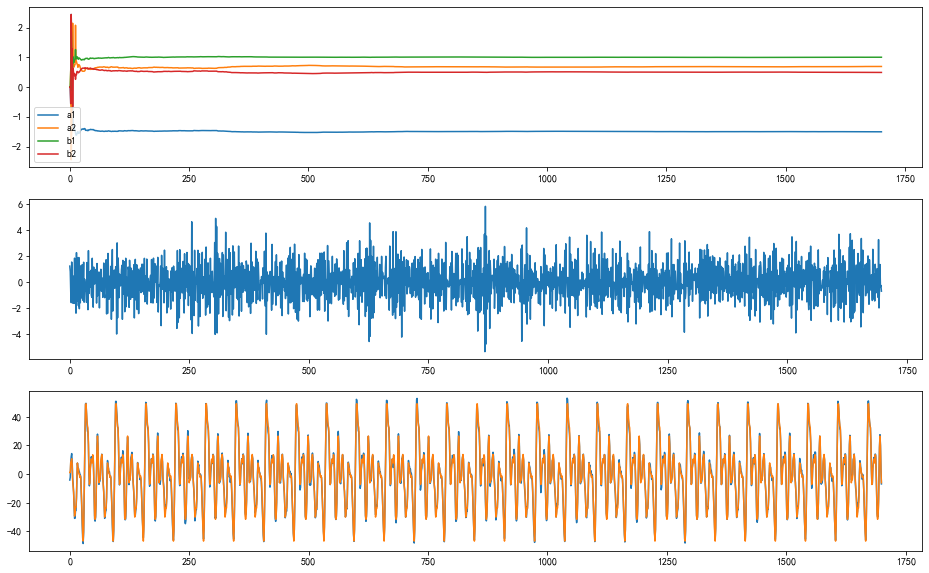

In [29]:
# RIV-4 辅助变量法，纯滞后
# 参数初始化
na = 2
nb = 2
nMax = max(na, nb)
L = 1700 # 数据长度
a = 1000
mu = 0.99

# 序列初始化
h = np.zeros((L + nMax, na + nb, 1))
h1 = np.zeros((L + nMax, na + nb, 1)) # 辅助向量
P = np.array([a**2 * np.eye((na + nb))] * (L + nMax))
s = np.zeros(L + nMax) # 数
Inn = np.zeros(L + nMax) # 数
err = np.zeros(L + nMax) # 数 残差
K = np.zeros((L + nMax, na + nb, 1))
Theta = np.zeros((L + nMax, na + nb, 1))   # [a1,a2,b1,b2].T
J = np.zeros(L + nMax) # 数

np.random.seed(1000)
# u = np.linspace(0, 10, nMax + L).reshape(-1,1)
# z = u ** 1.5 + 1+ np.random.randn(len(u), 1)*0.5
u = data[:, 0]
z = data[:, 1]
v1 = np.zeros(len(u))
z_pre = np.ones((len(z), 1))
# print(u)
# print(z)
# plt.plot(range(len(z)), z)
# plt.show()


for k in range(nMax, L + nMax):
    for i in range(na):
        h[k][i] = -1 * z[k - i - 1]
        h1[k][i] = u[k - i - 1]
    for j in range(nb):
        h[k][na + j] = u[k - j - 1]
        h1[k][na + j] = u[k - j - 1 - na]

        
    s[k] = h[k].T @ P[k - 1] @ h1[k] + 1.0
    Inn[k] = z[k] - h[k].T @ Theta[k - 1]
    K[k] = P[k - 1] @ h1[k] / s[k]
    P[k] = P[k-1] - K[k] @ h[k].T @ P[k-1]
    Theta[k] = Theta[k - 1] + K[k] * Inn[k]
    J[k] = J[k-1] + Inn[k]**2 / s[k]
    v1[k] = np.sqrt(J[k] / (k - nMax + 1))

plt.figure(1,figsize=(16,10))

ax4 = plt.subplot(3,1,1)
ax4.plot(range(L + nMax),Theta[:,0],
        range(L + nMax),Theta[:,1],
        range(L + nMax),Theta[:,2],
        range(L + nMax),Theta[:,3],)
ax4.legend(["a1", "a2", "b1", "b2"])

print(np.sqrt(J[L + nMax - 1]/L))
Theta_hat = np.sum(Theta[-21:-1][:,:,0], axis=0)/ 20
print(Theta_hat.T)

# 计算残差
err = [] # 数 残差
for k in range(2*nMax, L + nMax):
    for i in range(na):
        h[k][i] = -1 * z[k - i - 1]
    for j in range(nb):
        h[k][na + j] = u[k - j - 1]
        
    err.append(z[k] - h[k].T @ Theta_hat)
    z_pre[k] = h[k].T @ Theta_hat

err = np.array(err).reshape((-1,1))    
ax3 = plt.subplot(3,1,2)
ax3.plot(range(len(err)), err)

for k in range(2*nMax, L + nMax):
    for i in range(na):
        h[k][i] = -1 * z_pre[k - i - 1]
    for j in range(nb):
        h[k][na + j] = u[k - j - 1]
        
    z_pre[k] = h[k][0: na + nb].T @ Theta_hat[0: na + nb]
    
ax5 = plt.subplot(3,1,3)
ax5.plot(range(L), z[nMax:nMax+L],range(L), z_pre[nMax:nMax+L])
# ax5.set_ylabel("$"+"z_pre"+"$",fontsize=10)

4.35405404160649
[-1.09  0.29  1.    0.94]


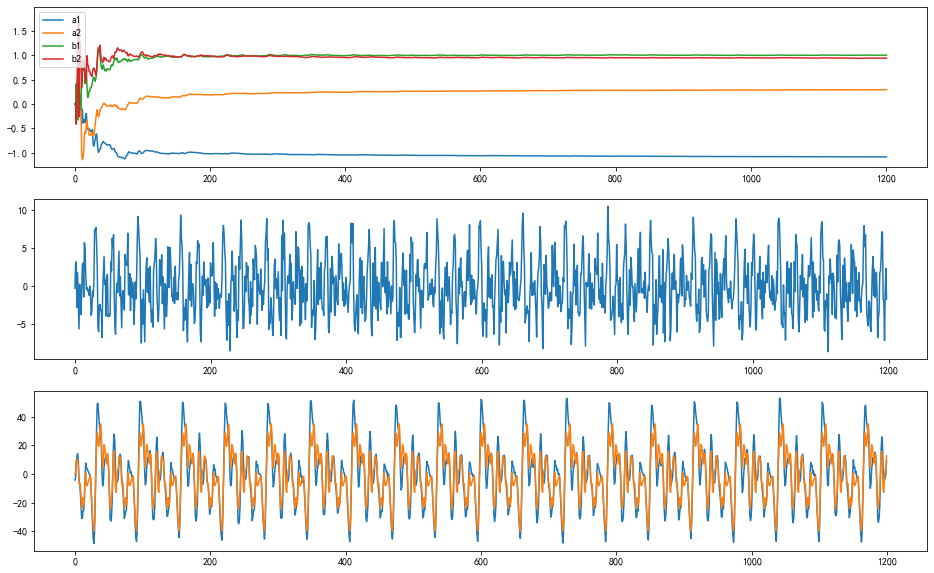

In [20]:
# RIV-1 辅助变量法，平滑  不太好使，依赖于平滑系数
# 参数初始化
na = 2
nb = 2
nMax = max(na, nb)
L = 1200 # 数据长度
a = 1

u = data[:, 0]
z = data[:, 1]
x = np.zeros((len(z), 1))
z_pre = np.zeros((len(z), 1))

# 序列初始化
h = np.zeros((L + nMax, na + nb, 1))
h1 = np.zeros((L + nMax, na + nb, 1))
P = np.array([a**2 * np.eye((na + nb))] * (L + nMax))
s = np.zeros(L + nMax) # 数
Inn = np.zeros(L + nMax) # 数
K = np.zeros((L + nMax, na + nb, 1))
Theta = np.zeros((L + nMax, na + nb, 1))
ThetaIV = np.zeros((L + nMax, na + nb, 1))
alpha = 0.01
dTime = 2
J = np.zeros(L + nMax) # 数


for k in range(nMax, L + nMax):
    for i in range(na):
        h[k][i] = -1 * z[k - i - 1]
        h1[k][i] = -1 * x[k - i - 1]
    for j in range(nb):
        h[k][na + j] = u[k - j - 1]
        h1[k][na + j] = u[k - j - 1]

    s[k] = h[k].T @ P[k - 1] @ h1[k] + 1.0
    Inn[k] = z[k] - h[k].T @ Theta[k - 1]
    K[k] = P[k - 1] @ h1[k] / s[k]
    P[k] = P[k-1] - K[k] @ h[k].T * P[k - 1]
    Theta[k] = Theta[k - 1] + K[k] * Inn[k]
    J[k] = J[k-1] + Inn[k]**2 / s[k]
    if k >= dTime:
        ThetaIV[k] = (1 - alpha) * ThetaIV[k - 1] + alpha * Theta[k - dTime]
    else:
        ThetaIV[k] = Theta[k]
    x[k] = h1[k].T @ ThetaIV[k]

plt.figure(1,figsize=(16,10))

ax4 = plt.subplot(3,1,1)
ax4.plot(range(L + nMax),Theta[:,0],
        range(L + nMax),Theta[:,1],
        range(L + nMax),Theta[:,2],
        range(L + nMax),Theta[:,3],)
ax4.legend(["a1", "a2", "b1", "b2"])

print(np.sqrt(J[L + nMax - 1]/L))
Theta_hat = np.sum(Theta[-21:-1][:,:,0], axis=0)/ 20
print(Theta_hat.T)

# 计算残差
err = [] # 数 残差
for k in range(2*nMax, L + nMax):
    for i in range(na):
        h[k][i] = -1 * z[k - i - 1]
    for j in range(nb):
        h[k][na + j] = u[k - j - 1]
        
    err.append(z[k] - h[k].T @ Theta_hat)
    z_pre[k] = h[k].T @ Theta_hat

err = np.array(err).reshape((-1,1))    
ax3 = plt.subplot(3,1,2)
ax3.plot(range(len(err)), err)

for k in range(2*nMax, L + nMax):
    for i in range(na):
        h[k][i] = -1 * z_pre[k - i - 1]
    for j in range(nb):
        h[k][na + j] = u[k - j - 1]
        
    z_pre[k] = h[k][0: na + nb].T @ Theta_hat[0: na + nb]
    
ax5 = plt.subplot(3,1,3)
ax5.plot(range(L), z[nMax:nMax+L],range(L), z_pre[nMax:nMax+L])
# ax5.set_ylabel("$"+"z_pre"+"$",fontsize=10)